In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Part 3

- Assume two correlated stock prices

$
dS_t^1 = rS_t^1 dt + \sigma_1 S_t^1 dW_t^1
$

$
dS_t^2 = rS_t^2 dt + \sigma_2 S_t^2 dW_t^2
$

where $(W^1, W^2)$ are two standard Brownian motions under $Q$ with the correlation $\rho$. Suppose that $S_0^1 = S_0^2$.

- Let us consider an autocallable barrier reverse convertible which is an example of a structured note.

- According to this contract, the holder receives the coupon payments $c$ on dates $0 < t_1 < \ldots < t_n = T$ and principal payment $K$ at $T$, unless one of the two events below happen:

- (i) if $S_{t_i}^1 \geq TB$ and $S_{t_i}^2 \geq TB$ for some $i < n$, where  
$TB \geq S_0^1 = S_0^2$ is the trigger barrier. In this case, the contract is terminated early, and the holder receives the final payment of $c + K$.

- (ii) if $S_t^1 \leq B$ or $S_t^2 \leq B$ for some $t < T$, where $B < S_0^1 = S_0^2$ is the lower barrier. In this case, the coupon payments stay the same but the terminal payment (in case the contract is not autocalled before) is given by  $c + K - (K - \min(S_T^1, S_T^2))^+$

- Assume that $S_0^1 = S_0^2 = K = TB = 100$, $t_i = iT/n$ and  
$t_i - t_{i-1} = 0.25$. Take some parameter values for  
$(r, \sigma_1, \sigma_2, \rho, TB, T, n)$. Also, take a reasonably large number $N$ of simulations and number $m$ of discretization steps. Write a program that determines the value of coupon $c$ that makes the contract value $V_0 = 100$ at time 0.

In [157]:
rng = np.random.default_rng(seed=405)

In [250]:
r = 0.05                # model parameter r
sigma_1 = 0.1           # model parameter σ2
sigma_2 = 0.2           # model parameter σ1
rho = 0.2               # correlation between BMs
TB = 100                # trigger barrier
B = 80                  # lower barrier
K = 100                 # principal payment
S1_0 = 100              # S1 initial price
S2_0 = 100              # S2 initial price
T = 30                  # maturity date
n = T * 4               # number of coupon payments
coupon_interval = 0.25  # t_i - t_{i-1}
m = n * 5               # number of discretization steps, must be a multiple of n
dt = T / m              # discretization step
V0 = 100                # target contract value
N = 10000                # number of simulations
c = 10                  # coupon payment, need to find
idx = np.arange(m/n, m+1, m/n, dtype=int) # indexes of coupon payments moments

In [159]:
def sample_paths(S1_0=100, S2_0=100, r=0.05, sigma_1=0.1, sigma_2=0.2, rho=0.4, N=20, m=240, T=30):
    # defining timestep
    dt = T / m
    # creating empty arrays
    S1 = np.zeros((m+1, N))
    S2 = np.zeros((m+1, N))
    # setting initial value
    S1[0] = np.ones(N) * S1_0
    S2[0] = np.ones(N) * S2_0
    # sampling two correlated N(0, 1) arrays
    Y = rng.normal(size=(2, m, N))
    Z1 = Y[0]
    Z2 = rho * Y[0] + np.sqrt(1 - rho**2) * Y[1]
    # calculating paths
    S1[1:] = np.cumprod(np.exp((r - sigma_1**2 / 2) * dt + sigma_1 * Z1 * np.sqrt(dt)), axis=0) * S1_0
    S2[1:] = np.cumprod(np.exp((r - sigma_2**2 / 2) * dt + sigma_2 * Z2 * np.sqrt(dt)), axis=0) * S2_0
    return S1, S2

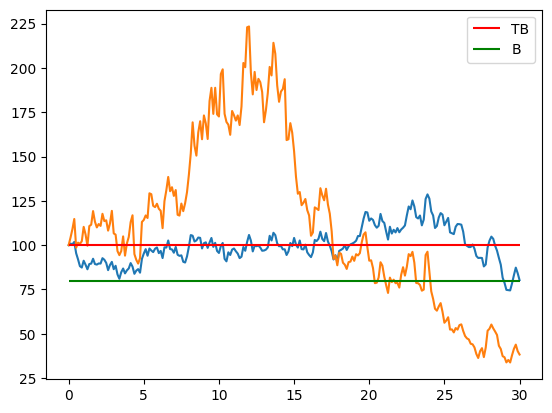

In [244]:
t = np.linspace(0, T, m+1)
p = sample_paths(N=1, rho=0.8, r=0.01)
plt.plot(t, p[0])
plt.plot(t, p[1])
plt.hlines(TB, 0, T, colors='red', label='TB')
plt.hlines(B, 0, T, colors='green', label='B')
plt.legend()
plt.show()

In [245]:
def price(S1_0=100, S2_0=100, r=0.05, sigma_1=0.1, sigma_2=0.2, rho=0.4, N=20, m=240, T=30, n=120, TB=100, B=80, K=100, c=5):
    # defining time grid
    t = np.linspace(0, T, m+1)
    # sampling N pairs of paths
    S1, S2 = sample_paths(S1_0=S1_0, S2_0=S2_0, r=r, sigma_1=sigma_1, sigma_2=sigma_2, rho=rho, N=N, m=m, T=T)

    idx = np.arange(m/n, m+1, m/n, dtype=int) # indexes of coupon payments moments

    # defining indicator arrays
    # TB_not_triggered[i] == 1 means upper barrier did not triggered before the i-th coupon payment moment (i=1,..., n)
    # TB_not_triggered[i] == 0 means upper barrier triggered before or at the i-th coupon payment moment (i=1,..., n)
    # TB_not_triggered[-1] is useless
    TB_not_triggered = np.ones((n+1, N))
    TB_not_triggered[1:] = np.cumprod(1 - np.where(S1[idx] >= TB, 1, 0) * np.where(S2[idx] >= TB, 1, 0), axis=0)
    # B_triggered = 1 means lower barrier triggered during t < T
    B_triggered = np.min(np.min(np.array([S1, S2]), axis=1), axis=0) <= B

    # calculating payoff schedule
    payoffs = np.zeros((n, N))
    payoffs[:-1] = c * TB_not_triggered[:-2] + K * TB_not_triggered[:-2] * (1 - TB_not_triggered[1:-1])
    payoffs[-1] = (c + K) * TB_not_triggered[-2] * (1 - B_triggered) + (c + K - np.maximum(K - np.min([S1[m], S2[m]], axis=0), 0)) * TB_not_triggered[-2] * B_triggered # ¯\_(ツ)_/¯

    # calculating price
    price = np.mean(np.dot(np.exp(-r * t[idx]), payoffs))
    return price

In [252]:
from scipy.optimize import root_scalar

In [270]:
def find_c(S1_0=100, S2_0=100, r=0.05, sigma_1=0.1, sigma_2=0.2, rho=0.4, N=20, m=240, T=30, n=120, TB=100, B=80, K=100, V0=100):
    func = lambda c: price(S1_0=S1_0, S2_0=S2_0, r=r, sigma_1=sigma_1, sigma_2=sigma_2, rho=rho, N=N, m=m, T=T, n=n, TB=TB, B=B, K=K, c=c) - V0
    c_star = root_scalar(func, method='bisect', bracket=[0, V0])
    return c_star

In [272]:
c_star = find_c(S1_0=S1_0, S2_0=S2_0, r=r, sigma_1=sigma_1, sigma_2=sigma_2, rho=rho, N=N, m=m, T=T, n=n, TB=TB, B=B, K=K, V0=V0)['root']
c_star, price(S1_0=S1_0, S2_0=S2_0, r=r, sigma_1=sigma_1, sigma_2=sigma_2, rho=rho, N=N, m=m, T=T, n=n, TB=TB, B=B, K=K, c=c_star)

(1.2913961087249959, np.float64(100.00844031708354))